# Introduction

In this notebook we use Google's Tensorflow library to predict the price of the diamonds knowing its characteristics.

- First we will create a simple linear model based on one feature. 
- Then we will expand this model to become a multi-valued linear regression model that includes all the features of the dataset. 
- After that, we will create a deep neural network (dnn) model based on one feature. 
- And finally we will expand the dnn model to include all the features. 

After we create the four models, we will compare their performance and manage each model's loss.

### Importing important libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)
import tensorflow as tf
from tensorflow.keras.layers import Dense, Normalization
from tensorflow.keras.models import Model

from scipy import stats

2021-12-28 20:53:44.699746: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-28 20:53:44.699789: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## The data

### Getting the data

Reading the dataset into a Pandas Dataframe Object

In [3]:
data = pd.read_csv("diamonds.csv")

In [4]:
data.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


### Cleaning the data
The dataset has no null values as seen:

In [34]:
data.isna().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

The `color` and `cut` and `clarity` columns are categorical, not numeric. So the next step is to one-hot encode the values in the columns with `pd.get_dummies`.

In [5]:
data = pd.get_dummies(data, columns=['color'], prefix='color')
data = pd.get_dummies(data, columns=['cut'], prefix='cut')
data = pd.get_dummies(data, columns=['clarity'], prefix='clarity')
data.head()

,carat,depth,table,price,x,y,z,color_D,color_E,color_F,...,cut_Premium,cut_Very Good,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,326,3.95,3.98,2.43,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,0.21,59.8,61.0,326,3.89,3.84,2.31,0,1,0,...,1,0,0,0,1,0,0,0,0,0
2,0.23,56.9,65.0,327,4.05,4.07,2.31,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,0.29,62.4,58.0,334,4.20,4.23,2.63,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,0.31,63.3,58.0,335,4.34,4.35,2.75,0,0,0,...,0,0,0,0,0,1,0,0,0,0


Remove outliers that have z score higher than 3 or lower than -3 

In [6]:
data = data[(np.abs(stats.zscore(data)) < 3).all(axis=1)]


### Split the data into training and test sets
Now, split the dataset into a training set and a test set. We will use the test set in the final evaluation of the models.

In [7]:
train_dataset = data.sample(frac=0.8, random_state=0)
test_dataset = data.drop(train_dataset.index)

### Split features from labels
Separate the target value —the price, also called the label— from the features. This label is the value that we will train the model to predict.

In [8]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('price')
test_labels = test_features.pop('price')


## Normalization
In the table of statistics it's easy to see that the feautures have different ranges. some range in the units , some in the hundreds, some in the thousands.

In [9]:
train_dataset[['carat', 'depth', 'table', 'price', 'x', 'y', 'z']].describe().transpose()[['mean', 'std']]

,mean,std
carat,0.785626,0.416910
depth,61.611885,1.096740
table,57.370539,2.002749
price,3715.782066,3427.572015
x,5.744671,1.032990
y,5.745005,1.026416
z,3.538966,0.633848


It is good practice to normalize features that have different ranges.

If we skip normalizing the features, the model will still converge (ie: reach the optimum loss. ie: become able to predict and perform regression as best as it can), However, normalization makes training much more stable and faster in performance.

### The Normalization layer
The tf.keras.layers.Normalization is a clean and simple way to add feature normalization into our model.

The first step is to create the layer:

In [10]:
normalizer = tf.keras.layers.Normalization(axis=-1)

Then, fit the state of the preprocessing layer to the data by calling Normalization.adapt:

In [11]:
normalizer.adapt(np.array(train_features))

2021-12-28 20:55:28.946451: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-28 20:55:28.946562: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-28 20:55:28.946607: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-IMB35Q1): /proc/driver/nvidia/version does not exist
2021-12-28 20:55:28.949044: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Calculate the mean and variance, and store them in the layer:

In [12]:
print(normalizer.mean.numpy())

[[ 0.786 61.612 57.371  5.745  5.745  3.539  0.149  0.2    0.181  0.202
   0.162  0.106  0.     0.     0.     0.425  0.317  0.258  0.     0.
   0.3    0.202  0.199  0.299  0.     0.   ]]


When the layer is called, it returns the input data, with each feature independently normalized:

In [13]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
    print('First example:', first)
    print()
    print('Normalized:', normalizer(first).numpy())


First example: [[ 1.1  61.5  56.    6.61  6.65  4.08  0.    0.    0.    0.    1.    0.
   0.    0.    0.    1.    0.    0.    0.    0.    1.    0.    0.    0.
   0.    0.  ]]

Normalized: [[ 0.75 -0.1  -0.68  0.84  0.88  0.85 -0.42 -0.5  -0.47 -0.5   2.27 -0.35
   0.    0.    0.    1.16 -0.68 -0.59  0.    0.    1.53 -0.5  -0.5  -0.65
   0.    0.  ]]


## Linear regression
We start with linear regression using one and several variables.

### Linear regression with one variable
we Begin with a single-variable linear regression to predict 'price' from 'carat'.

Training a model with tf.keras typically starts by defining the model architecture. Use a tf.keras.Sequential model, which represents a sequence of steps.

There are two steps in your single-variable linear regression model:

- Normalize the `carat` input features using the `tf.keras.layers.Normalization` preprocessing layer.
- Apply a linear transformation (`y = mx + b`) to produce 1 output using a linear layer `tf.keras.layers.Dense`.



In [14]:
carat = np.array(train_features['carat'])

carat_normalizer = Normalization(input_shape=[1, ], axis=None)
carat_normalizer.adapt(carat)


Build the Keras Sequential model:

In [15]:
carat_model = tf.keras.Sequential([
    carat_normalizer,
    Dense(units=1)
])

carat_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


This model will predict 'price' from 'carat'.

If we run the untrained model on the first 10 'carat' values, the output won't be good because we still need to train the model on the data.

In [16]:
carat_model.predict(carat[:10])


array([[ 0.711],
       [-1.076],
       [ 0.508],
       [-1.076],
       [-0.035],
       [ 1.005],
       [-0.827],
       [-0.533],
       [-1.189],
       [ 1.548]], dtype=float32)

Once the model is built, we compile the it using the Keras `Model.compile` method. We give it a loss function to optimise (mean absolute error in our case) and an optimiser (we choose `tf.keras.optimizers.Adam`).

In [17]:
carat_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

Use Keras Model.fit to execute the training for 100 epochs:

In [78]:
history = carat_model.fit(
    train_features['carat'],
    train_labels,
    epochs=100,
    # Calculate validation results on 20% of the training data.
    validation_split=0.2)


Epoch 1/100
680/680 [==============================] - 1s 1ms/step - loss: 3655.8179 - val_loss: 3752.0173
Epoch 2/100
680/680 [==============================] - 1s 1ms/step - loss: 3587.7981 - val_loss: 3684.1125
Epoch 3/100
680/680 [==============================] - 1s 1ms/step - loss: 3519.7683 - val_loss: 3616.2131
Epoch 4/100
680/680 [==============================] - 1s 1ms/step - loss: 3451.7397 - val_loss: 3548.3010
Epoch 5/100
680/680 [==============================] - 1s 1ms/step - loss: 3383.7136 - val_loss: 3480.3906
Epoch 6/100
680/680 [==============================] - 1s 2ms/step - loss: 3316.0159 - val_loss: 3413.1526
Epoch 7/100
680/680 [==============================] - 1s 2ms/step - loss: 3250.2029 - val_loss: 3347.8667
Epoch 8/100
680/680 [==============================] - 1s 2ms/step - loss: 3186.5837 - val_loss: 3283.4985
Epoch 9/100
680/680 [==============================] - 1s 2ms/step - loss: 3123.6130 - val_loss: 3219.1140
Epoch 10/100
680/680 [===============

Visualize the model's training progress using the stats stored in the history object:

In [79]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()


,loss,val_loss,epoch
95,741.401428,754.158325,95
96,741.401978,754.151855,96
97,741.401306,754.153442,97
98,741.406677,754.159424,98
99,741.403015,754.161499,99


In [80]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss') 
    plt.xlabel('Epoch')
    plt.ylabel('Error [price]')
    plt.legend()
    plt.grid(True)
    plt.show()


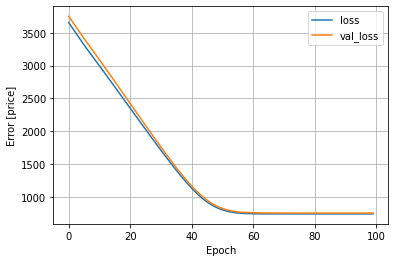

In [81]:
plot_loss(history) 


Collect the results on the test set for later:

In [82]:
test_results = {}

test_results['carat_model'] = carat_model.evaluate(
    test_features['carat'],
    test_labels, verbose=0)


Since this is a single variable regression, it's easy to view the model's predictions as a function of the input:

In [83]:
x = tf.linspace(0.0, 4, 50)
y = carat_model.predict(x)


In [92]:
def plot_carat(x, y):
    plt.figure(figsize=(15, 10))
    plt.scatter(train_features['carat'], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('carat')
    plt.ylabel('price')
    plt.legend()


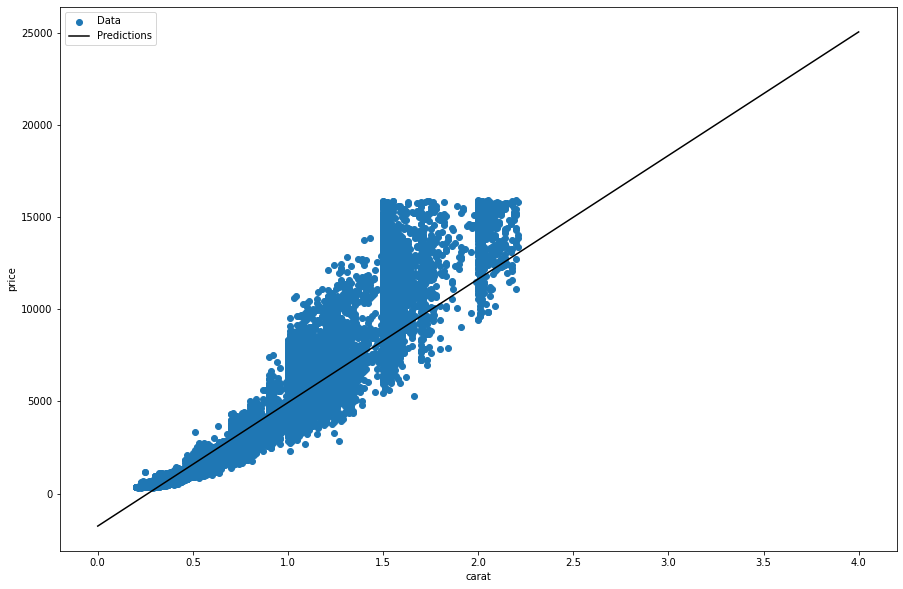

In [93]:
plot_carat(x,y)

### Linear regression with multiple inputs
We use an almost identical setup to make predictions based on multiple inputs. This model still does the same `y = mx + b` except that `m` is a matrix and `b` is a vector.

We create a two-step Keras Sequential model again with the first layer being normalizer (tf.keras.layers.Normalization(axis=-1)), defined earlier, and adapted to the whole dataset:

In [94]:
linear_model = tf.keras.Sequential([
    normalizer,
    Dense(units=1)
])

Configure the model with Keras Model.compile and train with Model.fit for 100 epochs:

In [95]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [96]:
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Calculate validation results on 20% of the training data.
    validation_split=0.2)


Epoch 1/100
680/680 [==============================] - 2s 3ms/step - loss: 3655.9158 - val_loss: 3752.4978
Epoch 2/100
680/680 [==============================] - 1s 2ms/step - loss: 3587.7925 - val_loss: 3685.0122
Epoch 3/100
680/680 [==============================] - 1s 1ms/step - loss: 3519.6392 - val_loss: 3617.5364
Epoch 4/100
680/680 [==============================] - 1s 1ms/step - loss: 3451.5044 - val_loss: 3550.0747
Epoch 5/100
680/680 [==============================] - 1s 1ms/step - loss: 3383.6069 - val_loss: 3482.6980
Epoch 6/100
680/680 [==============================] - 1s 2ms/step - loss: 3316.7263 - val_loss: 3414.8271
Epoch 7/100
680/680 [==============================] - 1s 2ms/step - loss: 3249.9233 - val_loss: 3346.4346
Epoch 8/100
680/680 [==============================] - 2s 3ms/step - loss: 3182.8171 - val_loss: 3277.5029
Epoch 9/100
680/680 [==============================] - 1s 1ms/step - loss: 3115.5090 - val_loss: 3208.3713
Epoch 10/100
680/680 [===============

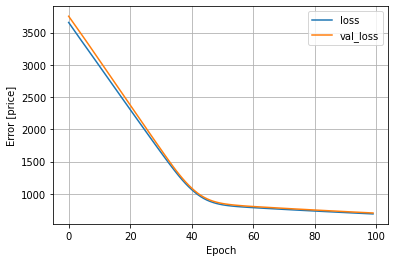

In [97]:
plot_loss(history)


In [98]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)


## Regression with a deep neural network (DNN)

Now, we will implement single-input and multiple-input DNN models.

The code is basically the same except the model is expanded to include some "hidden" non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.

These models will contain a few more layers than the linear model:

* The normalization layer, as before (with carat_normalizer for a single-input model and normalizer for a multiple-input model).
* Two hidden, non-linear, Dense layers with the ReLU (relu) activation function nonlinearity.
* A linear Dense single-output layer.

Both models will use the same training procedure so the compile method is included in the build_and_compile_model function below.

In [99]:
def build_and_compile_model(norm):
    model = tf.keras.Sequential([
        norm,
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model


### Regression using a DNN and a single input
Create a DNN model with only `carat` as input and `carat_normalizer` (defined earlier) as the normalization layer:

In [100]:
dnn_carat_model = build_and_compile_model(carat_normalizer)


This model has quite a few more trainable parameters than the linear models:

In [101]:
dnn_carat_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                128       
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


Train the model with Keras Model.fit:

In [102]:
history = dnn_carat_model.fit(
    train_features['carat'],
    train_labels,
    validation_split=0.2,
    epochs=100)

Epoch 1/100
680/680 [==============================] - 2s 2ms/step - loss: 2947.2307 - val_loss: 1217.6450
Epoch 2/100
680/680 [==============================] - 2s 2ms/step - loss: 701.0593 - val_loss: 671.6646
Epoch 3/100
680/680 [==============================] - 2s 2ms/step - loss: 656.2385 - val_loss: 672.6628
Epoch 4/100
680/680 [==============================] - 2s 2ms/step - loss: 654.6115 - val_loss: 668.6214
Epoch 5/100
680/680 [==============================] - 2s 2ms/step - loss: 652.9515 - val_loss: 669.2366
Epoch 6/100
680/680 [==============================] - 2s 3ms/step - loss: 648.9518 - val_loss: 661.6861
Epoch 7/100
680/680 [==============================] - 2s 2ms/step - loss: 642.5068 - val_loss: 654.1884
Epoch 8/100
680/680 [==============================] - 2s 3ms/step - loss: 634.1464 - val_loss: 645.6691
Epoch 9/100
680/680 [==============================] - 2s 3ms/step - loss: 627.1179 - val_loss: 640.0326
Epoch 10/100
680/680 [==============================]

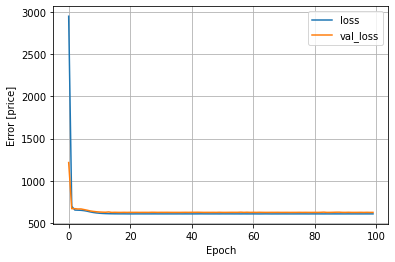

In [103]:
plot_loss(history)

If you plot the predictions as a function of 'Horsepower', you should notice how this model takes advantage of the nonlinearity provided by the hidden layers:

In [104]:
x = tf.linspace(0.0, 4, 50)
y = dnn_carat_model.predict(x)

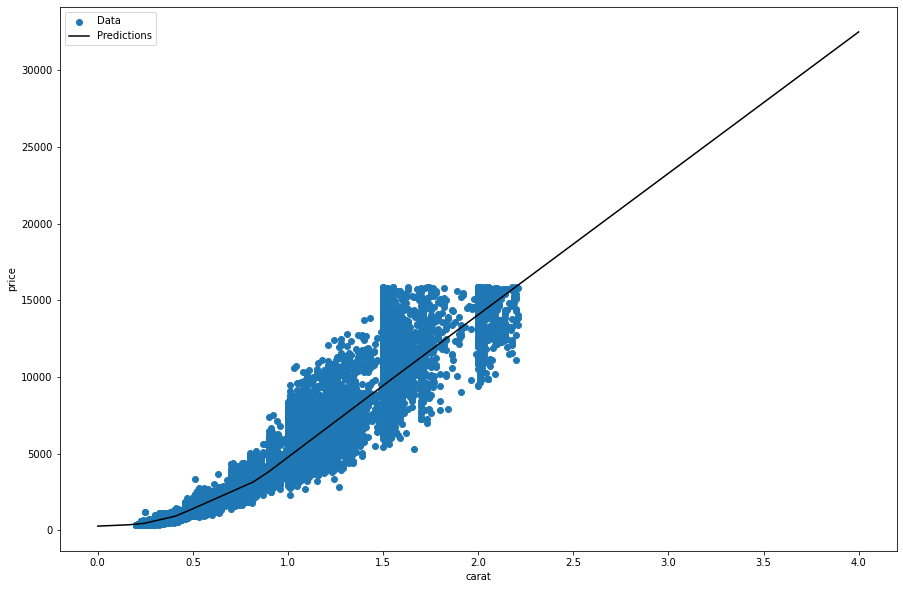

In [105]:
plot_carat(x, y)

In [106]:
test_results['dnn_carat_model'] = dnn_carat_model.evaluate(
    test_features['carat'], test_labels,
    verbose=0)

### Regression using a DNN and multiple inputs
Now we repeate the previous process using all the inputs. This will be the model with the least error, and the heighest performance.

In [107]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 26)               53        
 ion)                                                            
                                                                 
 dense_5 (Dense)             (None, 64)                1728      
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 6,006
Trainable params: 5,953
Non-trainable params: 53
_________________________________________________________________


In [108]:
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2, 
    epochs=100)

Epoch 1/100
680/680 [==============================] - 2s 2ms/step - loss: 2373.0701 - val_loss: 602.7947
Epoch 2/100
680/680 [==============================] - 2s 2ms/step - loss: 426.6758 - val_loss: 398.6442
Epoch 3/100
680/680 [==============================] - 2s 2ms/step - loss: 369.6849 - val_loss: 371.6504
Epoch 4/100
680/680 [==============================] - 2s 2ms/step - loss: 347.4308 - val_loss: 353.6231
Epoch 5/100
680/680 [==============================] - 2s 3ms/step - loss: 332.5948 - val_loss: 340.2848
Epoch 6/100
680/680 [==============================] - 2s 3ms/step - loss: 322.0063 - val_loss: 331.0986
Epoch 7/100
680/680 [==============================] - 2s 2ms/step - loss: 314.0320 - val_loss: 322.8036
Epoch 8/100
680/680 [==============================] - 2s 3ms/step - loss: 307.5008 - val_loss: 317.1478
Epoch 9/100
680/680 [==============================] - 1s 2ms/step - loss: 302.3612 - val_loss: 317.8089
Epoch 10/100
680/680 [==============================] 

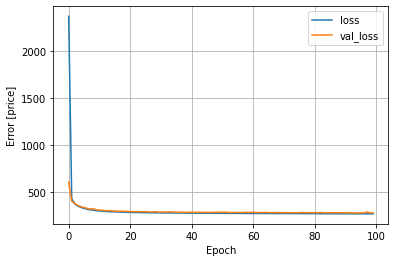

In [109]:
plot_loss(history)

In [110]:
test_results['dnn_model'] = dnn_model.evaluate(
    test_features, test_labels, verbose=0)

##### Performance
Since all models have been trained, we can review their test set performance:

In [111]:
pd.DataFrame(test_results, index=['Mean absolute error [price]']).T

,Mean absolute error [price]
carat_model,739.120483
linear_model,685.360657
dnn_carat_model,605.196655
dnn_model,261.021118


##### Make predictions
We can now make predictions with the dnn_model on the test set using Keras Model.predict and review the loss:

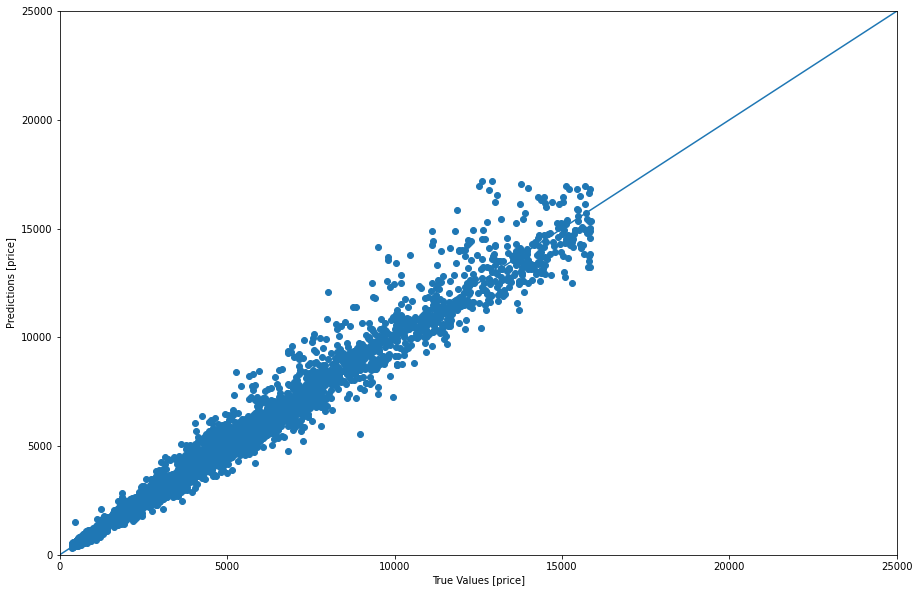

In [112]:
test_predictions = dnn_model.predict(test_features).flatten()

plt.figure(figsize=(15, 10))
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [price]')
plt.ylabel('Predictions [price]')
lims = [0, 25000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


The model predicts reasonably well.

Now, to check the error distribution:

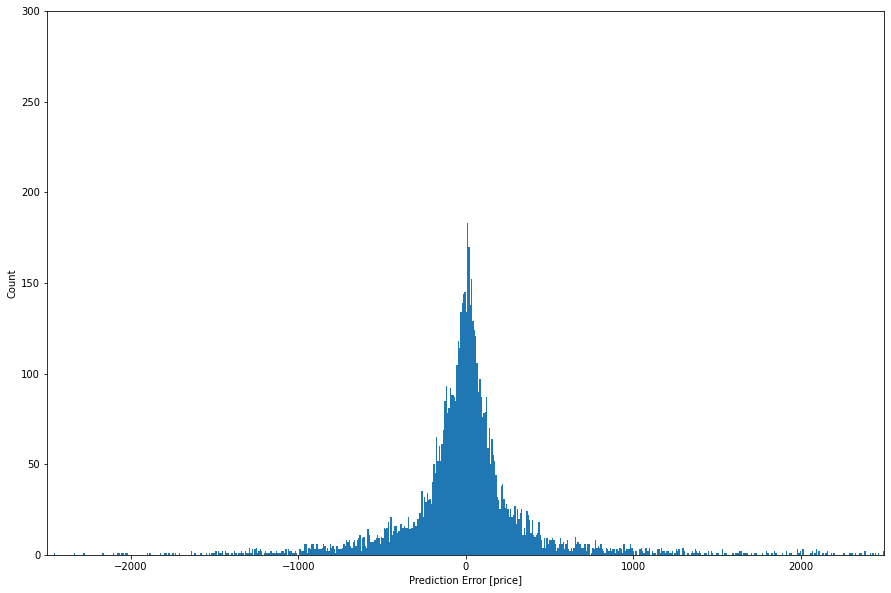

In [115]:
error = test_predictions - test_labels
plt.figure(figsize=(15, 10))
plt.hist(error, bins=1000)
plt.xlabel('Prediction Error [price]')
xlim = [-2500, 2500]
ylim = [0, 300]
plt.xlim(xlim)
plt.ylim(ylim)
_ = plt.ylabel('Count')


## Conclusion

We predicted the price of the diamonds using four types of models; linear and non-linear and single-valued and multi-valued, and we calculated the loss each one of these models in order to compare which one one of them performed better which turned out to be the non-linear multi-valued one.